In [1]:
# ALL imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [4]:
# Create dataframes train and test
train = pd.read_csv('E:\Level 4\L4S1\Data Mining and Warehousing\Assignment\Dataset\drugsComTrain_raw.csv')
test = pd.read_csv('E:\Level 4\L4S1\Data Mining and Warehousing\Assignment\Dataset\drugsComTest_raw.csv')

In [5]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [6]:
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [7]:
list(train) == list(test)

True

In [8]:
list(train)

['uniqueID',
 'drugName',
 'condition',
 'review',
 'rating',
 'date',
 'usefulCount']

In [9]:
train.values.shape[0], test.values.shape[0], train.values.shape[0] / test.values.shape[0]

(161297, 53766, 2.999981400885318)

In [10]:
train.condition.unique().size, test.condition.unique().size

(885, 709)

In [11]:
train.drugName.unique().size, test.drugName.unique().size

(3436, 2637)

In [12]:
# I previously did this by creating and sorting a dictionary -- here's an easier way with pandas! (Inspiration from Sayan Goswami)
conditions = train.condition.value_counts().sort_values(ascending=False)
conditions[:10]

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64

In [13]:
plt.rcParams['figure.figsize'] = [12, 8]

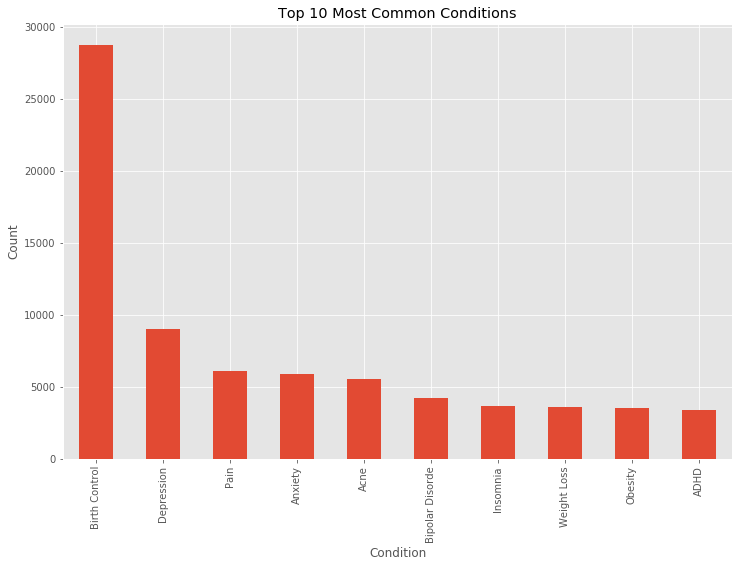

In [14]:
conditions[:10].plot(kind='bar')
plt.title('Top 10 Most Common Conditions')
plt.xlabel('Condition')
plt.ylabel('Count');

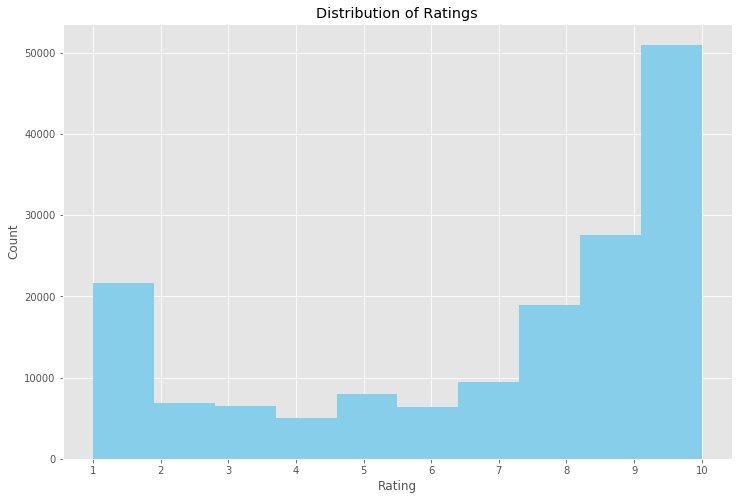

In [15]:
# Look at bias in review (also shown on 'Data' page in competition: distribution of ratings)
train.rating.hist(color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([i for i in range(1, 11)]);

Text(0, 0.5, 'Count')

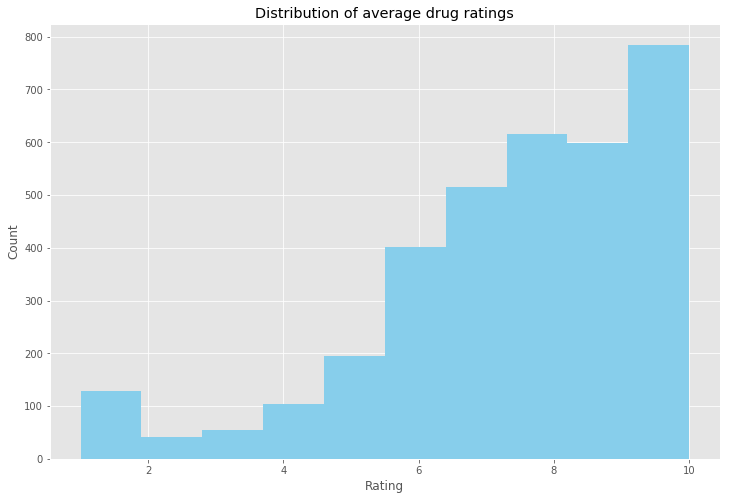

In [16]:
rating_avgs = (train['rating'].groupby(train['drugName']).mean())
rating_avgs.hist(color='skyblue')
plt.title('Distribution of average drug ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

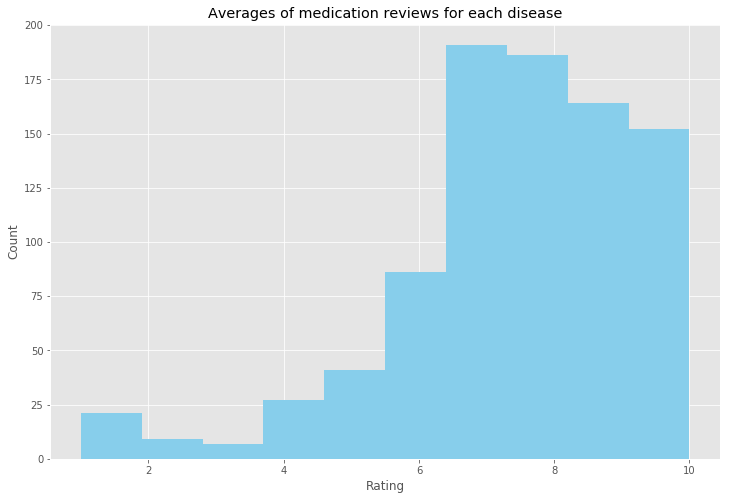

In [17]:
rating_avgs = (train['rating'].groupby(train['condition']).mean())
rating_avgs.hist(color='skyblue')
plt.title('Averages of medication reviews for each disease')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

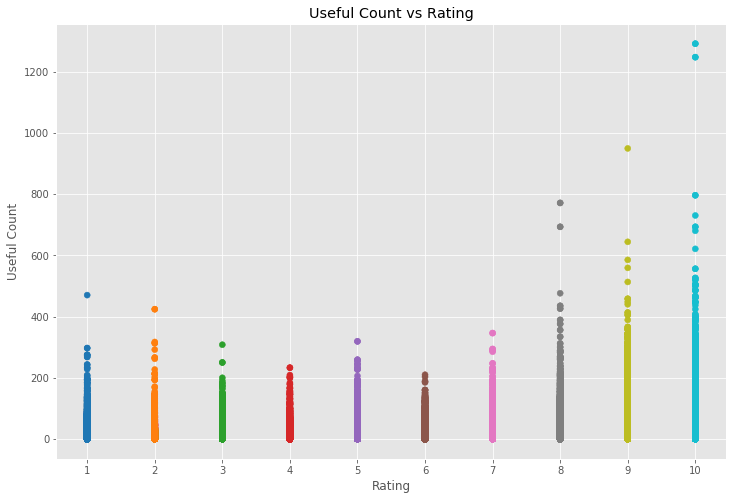

In [19]:
# Is rating correlated with usefulness of the review?
plt.scatter(train.rating, train.usefulCount, c=train.rating.values, cmap='tab10')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')
plt.xticks([i for i in range(1, 11)]);

In [20]:
# Create a list (cast into an array) containing the average usefulness for given ratings
use_ls = []

for i in range(1, 11):
    use_ls.append([i, np.sum(train[train.rating == i].usefulCount) / np.sum([train.rating == i])])
    
use_arr = np.asarray(use_ls)

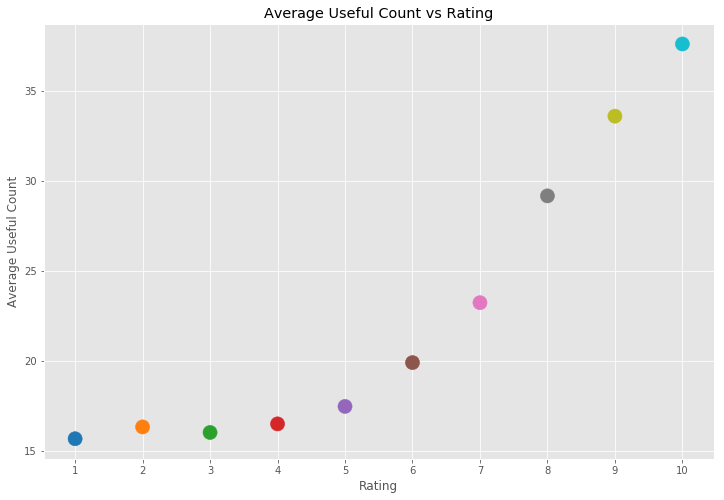

In [21]:
plt.scatter(use_arr[:, 0], use_arr[:, 1], c=use_arr[:, 0], cmap='tab10', s=200)
plt.title('Average Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Useful Count')
plt.xticks([i for i in range(1, 11)]);

In [22]:
# Sort train dataframe from most to least useful
useful_train = train.sort_values(by='usefulCount', ascending=False)
useful_train.iloc[:10]

,uniqueID,drugName,condition,review,rating,date,usefulCount
6716,96616,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291
33552,119152,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291
21708,131116,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247
4249,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247
146145,119151,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,5-Aug-08,949
58608,139141,Phentermine,Weight Loss,"""I have used this pill off and on for the past...",10,19-Oct-08,796
16889,52305,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,19-Oct-08,796
2039,62757,Citalopram,Depression,"""I responded after one week. The side effects ...",8,25-Mar-08,771
152838,89825,Celexa,Depression,"""I responded after one week. The side effects ...",8,25-Mar-08,771
5218,107655,Implanon,Birth Control,"""I was very nervous about trying Implanon afte...",10,19-Jul-10,730


In [23]:
# Print top 10 most useful reviews
for i in useful_train.review.iloc[:3]:
    print(i, '\n')

"I remember reading people&#039;s opinions, online, of the drug before I took it and it scared me away from it. Then I finally decided to give it a try and it has been the best choice I have made. I have been on it for over 4 months and I feel great. I&#039;m on 100mg and I don&#039;t have any side effects. When I first started I did notice that my hands would tremble but then it subsided. So honestly, don&#039;t listen to all the negativity because what doesn&#039;t work for some works amazing for others. So go based on youself and not everyone else. It may be a blessing in diguise. The pill is not meant to make you be all happy go lucky and see &quot;butterflies and roses&quot;, its meant to help put the chemicals in your mind in balance so you can just be who you are and not overly depressed. I still get sad some times, but that is normal, that is life, and it&#039;s up to people to take control to make a change. I did so by getting on this pill." 

"I remember reading people&#039;s

In [24]:
# Print 10 of the least useful reviews
for i in useful_train.review.iloc[-3:]:
    print(i, '\n')

"I received Implanon in May of 2008. I am due to have it removed in 6 months however, for the past year I have experienced decrease in sex drive, weight gain of 30lbs and also mood swings. My periods have been very scheduled and fairly regular which was great until 4-5 months ago when I missed a period then was on time the following 2 months. Last month I started a week early and it was unusually light, this month I started 2 1/2 weeks early and it has been off and on spotting for the past 5 days. I did call the helpline when I missed my period. They did not seem to concerned and I have not been able to find ANYwhere the birth rates on this specific birth control! I loved it until a year ago so the first half of my experience was great the last half no." 

"The only warning my gyno gave me was that I would be spotting for about 15 days after having the IUD inserted, which was a damn lie.  I spotted for a whole four weeks after the procedure.  My uterus chilled for two weeks before I st

In [29]:
sid = SentimentIntensityAnalyzer()

In [30]:
# Create list (cast to array) of compound polarity sentiment scores for reviews
sentiments = []

for i in train.review:
    sentiments.append(sid.polarity_scores(i).get('compound'))
    
sentiments = np.asarray(sentiments)

In [31]:
sentiments

array([-0.296 ,  0.8603,  0.7645, ..., -0.743 ,  0.6197,  0.6124])

In [33]:
useful_train['sentiment'] = pd.Series(data=sentiments)

In [34]:
useful_train = useful_train.reset_index(drop=True)
useful_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment
0,96616,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291,0.9772
1,119152,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291,0.9772
2,131116,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247,0.7739
3,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247,0.7739
4,119151,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,5-Aug-08,949,-0.6815


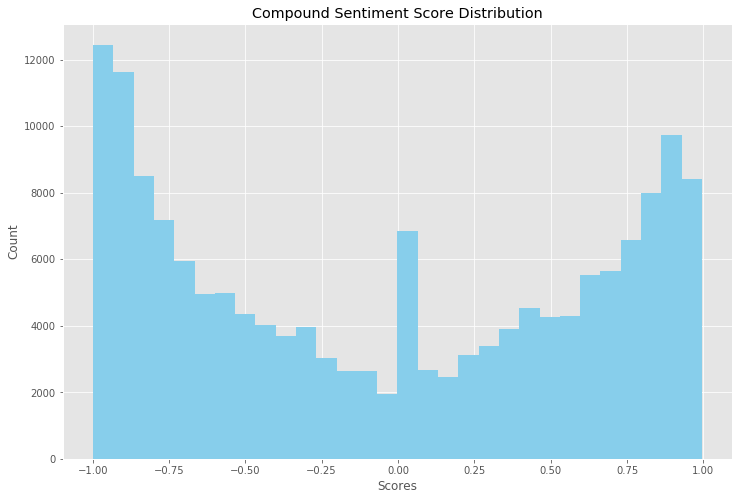

In [35]:
useful_train.sentiment.hist(color='skyblue', bins=30)
plt.title('Compound Sentiment Score Distribution')
plt.xlabel('Scores')
plt.ylabel('Count');

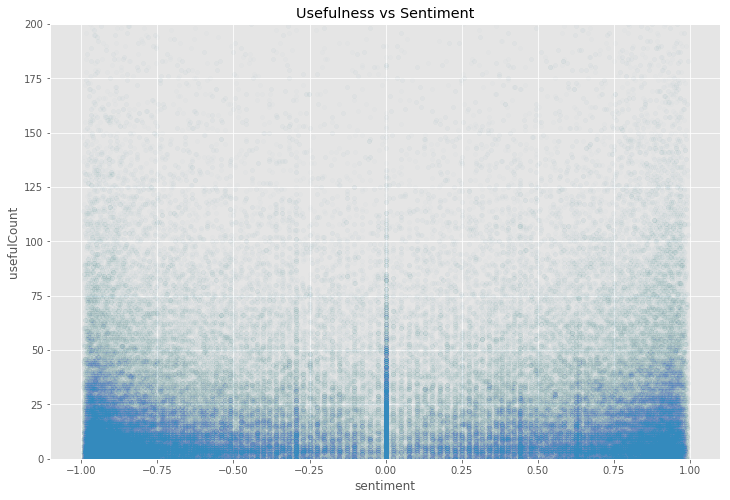

In [36]:
useful_train.plot(x='sentiment', y='usefulCount', kind='scatter', alpha=0.01)
plt.title('Usefulness vs Sentiment')
plt.ylim(0, 200);

In [37]:
temp_ls = []

for i in range(1, 11):
    temp_ls.append(np.sum(useful_train[useful_train.rating == i].sentiment) / np.sum(useful_train.rating == i))

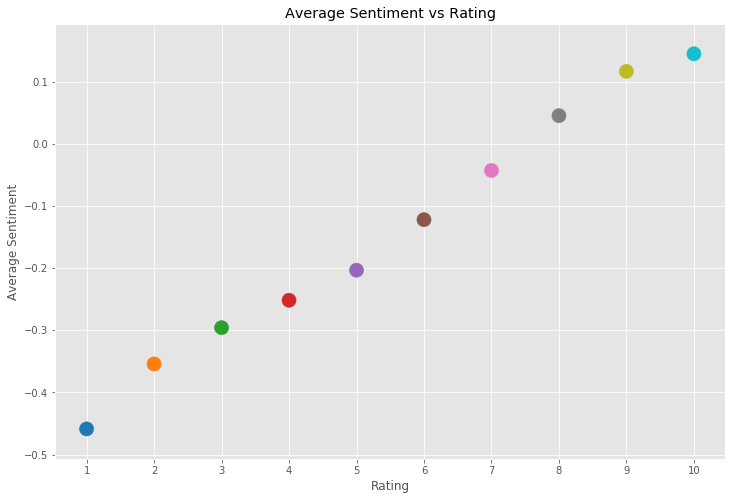

In [38]:
plt.scatter(x=range(1, 11), y=temp_ls, c=range(1, 11), cmap='tab10', s=200)
plt.title('Average Sentiment vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment')
plt.xticks([i for i in range(1, 11)]);

In [42]:
# Create a list of all drugs and their average ratings, cast to dataframe
rate_ls = []

for i in train.drugName.unique():
    
    # Only consider drugs that have at least 10 ratings
    if np.sum(train.drugName == i) >= 10:
        rate_ls.append((i, np.sum(train[train.drugName == i].rating) / np.sum(train.drugName == i)))
    
avg_rate = pd.DataFrame(rate_ls)

In [43]:
# Sort drugs by their ratings, look at top 10 best and worst rated drugs
avg_rate = avg_rate.sort_values(by=[1], ascending=False).reset_index(drop=True)
avg_rate[:10]

,0,1
0,Zutripro,10.000000
1,Chlorpheniramine / hydrocodone / pseudoephedrine,10.000000
2,Silver sulfadiazine,9.972222
3,Drixoral Cold and Allergy,9.948718
4,Dexbrompheniramine / pseudoephedrine,9.947368
5,Emend,9.900000
6,Aprepitant,9.900000
7,Tegaserod,9.812500
8,Zelnorm,9.687500
9,Cyanocobalamin,9.666667


In [44]:
avg_rate[-10:]

,0,1
1371,Prevnar 13,3.363636
1372,Fosamax,3.166667
1373,Blisovi 24 Fe,3.088889
1374,Opdivo,3.083333
1375,Miconazole,3.033000
1376,Monistat 7,3.032258
1377,Alendronate,2.954545
1378,Yuvafem,2.318182
1379,Monistat 1-Day or Night Combination Pack,1.416667
1380,ProAir RespiClick,1.193548


In [47]:
# Make dictionary of conditions, each value will be a dataframe of all of the drugs used to treat the given condition
help_dict = {}

# Iterate over conditions
for i in train.condition.unique():
    
    temp_ls = []
    
    # Iterate over drugs within a given condition
    for j in train[train.condition == i].drugName.unique():
        
        # If there are at least 10 reviews for a drug, save its name and average rating in temporary list
        if np.sum(train.drugName == j) >= 10:
            temp_ls.append((j, np.sum(train[train.drugName == j].rating) / np.sum(train.drugName == j)))
        
    # Save temporary list as a dataframe as a value in help dictionary, sorted best to worst drugs
    help_dict[i] = pd.DataFrame(data=temp_ls, columns=['drug', 'average_rating']).sort_values(by='average_rating', ascending=False).reset_index(drop=True)

In [48]:
help_dict['Birth Control'].iloc[:10]

,drug,average_rating
0,Plan B,8.674917
1,Lybrel,7.600000
2,Ortho Evra,7.470320
3,Kyleena,7.463576
4,Levonorgestrel,7.391031
5,Ortho-Cept,7.250000
6,Skyla,7.246359
7,Copper,7.235197
8,Beyaz,7.042553
9,Dienogest / estradiol,6.875000


In [49]:
help_dict['Depression'].iloc[:10]

,drug,average_rating
0,Desipramine,9.285714
1,Xanax XR,8.947368
2,Alprazolam,8.933144
3,Xanax,8.881579
4,Parnate,8.763158
5,St. john's wort,8.739130
6,Nefazodone,8.727273
7,Methylin ER,8.700000
8,Clomipramine,8.680000
9,Phenelzine,8.666667


In [50]:
help_dict['Acne'].iloc[:10]

,drug,average_rating
0,Benzoyl peroxide,8.869565
1,Benzaclin,8.865385
2,Milk of Magnesia,8.833333
3,Benzoyl peroxide / erythromycin,8.750000
4,Magnesium hydroxide,8.710000
5,Accutane,8.427273
6,Isotretinoin,8.392453
7,Onexton,8.357143
8,Retin-A,8.342857
9,Atralin,8.250000


In [51]:
help_dict['Acne'].iloc[-10:]

,drug,average_rating
64,Ethinyl estradiol / norethindrone,5.591930
65,Sulfamethoxazole / trimethoprim,5.557875
66,Junel Fe 1 / 20,5.404545
67,Loryna,5.162791
68,Tri-Previfem,4.984615
69,Junel Fe 1.5 / 30,4.961538
70,Gildess Fe 1.5 / 30,4.791667
71,SMZ-TMP DS,4.666667
72,Gildess Fe 1 / 20,4.594286
73,Estarylla,3.707317


In [52]:
# Creates TF-IDF vectorizer and transforms the corpus
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train.review)

# transforms test reviews to above vectorized format
X_test = vectorizer.transform(test.review)

In [53]:
# Create a column with binary rating indicating the polarity of a review
train['binary_rating'] = train['rating'] > 5

y_train_rating = train.binary_rating
clf = MultinomialNB().fit(X_train, y_train_rating)

# Evaluates model on test set
test['binary_rating'] = test.rating > 5
y_test_rating = test.binary_rating
pred = clf.predict(X_test)

print("Accuracy: %s" % str(clf.score(X_test, y_test_rating)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test_rating))

Accuracy: 0.7527247703009337
Confusion Matrix
[[ 3233   321]
 [12974 37238]]


In [55]:
# Trains random forest classifier
start = time.time()
rfc_rating = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 10000, min_samples_split = 0.001)
rfc_rating.fit(X_train, y_train_rating)
end = time.time()
print("Training time: %s" % str(end-start))

# Evaluates model on test set
pred = rfc_rating.predict(X_test)

print("Accuracy: %s" % str(rfc_rating.score(X_test, y_test_rating)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test_rating))

Training time: 227.97756123542786
Accuracy: 0.8310084439980657
Confusion Matrix
[[ 7252   131]
 [ 8955 37428]]


In [56]:
b = "'@#$%^()&*;!.-"
X_train = np.array(train['review'])
X_test = np.array(test['review'])

def clean(X):
    for index, review in enumerate(X):
        for char in b:
            X[index] = X[index].replace(char, "")
    return(X)

X_train = clean(X_train)
X_test = clean(X_test)
print(X_train[:2])

['"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"'
 '"My son is halfway through his fourth week of Intuniv We became concerned when he began this last week, when he started taking the highest dose he will be on For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation very unusual for him I called his doctor on Monday morning and she said to stick it out a few days See how he did at school, and with getting up in the morning The last two days have been problem free He is MUCH more agreeable than ever He is less emotional a good thing, less cranky He is remembering all the things he should Overall his behavior is better \r\nWe have tried many different medications and so far this is the most effective"']


In [57]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from keras.utils import to_categorical
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk

vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'),lowercase=True, max_features=5000)
#vectorizer = TfidfVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, max_features=5000)
test_train = np.concatenate([X_train, X_test])
print(test_train.shape)
X_onehot = vectorizer.fit_transform(test_train)
stop_words = vectorizer.get_stop_words()
print(type(X_onehot))

Using TensorFlow backend.


ModuleNotFoundError: No module named 'gensim'

In [58]:
pip install -U gensim

  Stored in directory: C:\Users\USER\AppData\Local\pip\Cache\wheels\73\6b\89\bb14fd56b74774a39a771a12f525a6a14c2c2692d3084ad048
  Stored in directory: C:\Users\USER\AppData\Local\pip\Cache\wheels\5f\ea\fb\5b1a947b369724063b2617011f1540c44eb00e28c3d2ca8692
Successfully built gensim smart-open
Note: you may need to restart the kernel to use updated packages.


In [59]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from keras.utils import to_categorical
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk

vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'),lowercase=True, max_features=5000)
#vectorizer = TfidfVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, max_features=5000)
test_train = np.concatenate([X_train, X_test])
print(test_train.shape)
X_onehot = vectorizer.fit_transform(test_train)
stop_words = vectorizer.get_stop_words()
print(type(X_onehot))

(215063,)
<class 'scipy.sparse.csr.csr_matrix'>


In [60]:
print(X_onehot.shape)
print(X_onehot.toarray())

(215063, 5000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
print(X_onehot.shape)
print(X_onehot.toarray())

(215063, 5000)


In [62]:
names_list = vectorizer.get_feature_names()
names = [[i] for i in names_list]
names = Word2Vec(names, min_count=1)
print(len(list(names.wv.vocab)))
print(list(names.wv.vocab)[:5])

5000
['00', '000', '00am', '00pm', '01']


In [63]:
def score_transform(X):
    y_reshaped = np.reshape(X['rating'].values, (-1, 1))
    for index, val in enumerate(y_reshaped):
        if val >= 8:
            y_reshaped[index] = 1
        elif val >= 5:
            y_reshaped[index] = 2
        else:
            y_reshaped[index] = 0
    y_result = to_categorical(y_reshaped)
    return y_result
    
    print(X_onehot)

In [64]:
y_train_test = pd.concat([train, test], ignore_index=True)
y_train = score_transform(y_train_test)
print(y_train)
print(y_train.shape)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
(215063, 3)


In [65]:
from numpy.random import seed

np.random.seed(1)
model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=len(vectorizer.get_feature_names())))
model.add(Dense(units=3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary

Instructions for updating:
Colocations handled automatically by placer.


<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x000001E8890D1898>>

In [66]:
history = model.fit(X_onehot[:-53866], y_train[:-53866], epochs=6, batch_size=128, verbose=1, validation_data=(X_onehot[157382:157482], y_train[157382:157482]))

Instructions for updating:
Use tf.cast instead.
Train on 161197 samples, validate on 100 samples
Epoch 1/6
161197/161197 [==============================] - 47s 292us/step - loss: 0.6259 - acc: 0.7496 - val_loss: 0.4068 - val_acc: 0.8700
Epoch 2/6
161197/161197 [==============================] - 45s 276us/step - loss: 0.4018 - acc: 0.8551 - val_loss: 0.1696 - val_acc: 0.9600
Epoch 3/6
161197/161197 [==============================] - 45s 277us/step - loss: 0.1802 - acc: 0.9455 - val_loss: 0.0751 - val_acc: 0.9900
Epoch 4/6
161197/161197 [==============================] - 45s 276us/step - loss: 0.0659 - acc: 0.9848 - val_loss: 0.0246 - val_acc: 1.0000
Epoch 5/6
161197/161197 [==============================] - 45s 279us/step - loss: 0.0275 - acc: 0.9950 - val_loss: 0.0109 - val_acc: 1.0000
Epoch 6/6
161197/161197 [==============================] - 44s 276us/step - loss: 0.0140 - acc: 0.9977 - val_loss: 0.0128 - val_acc: 1.0000


In [67]:
scores = model.evaluate(X_onehot[157482:], y_train[157482:], verbose=1)

57581/57581 [==============================] - 5s 86us/step


In [68]:
scores[1]

0.8951042878758412

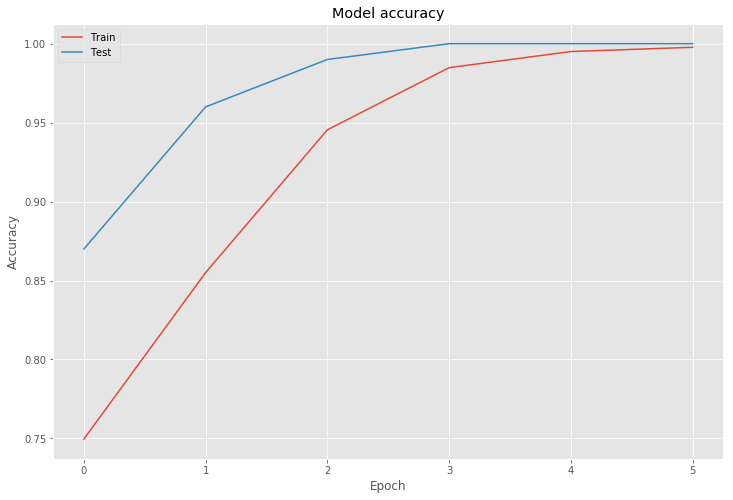

In [69]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()